# Occupancy Detection
#### **Experimental data used for binary classification (room occupancy) from Temperature, Humidity, Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.**

Dataset Source: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#

## Get the data

In [6]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Decompressing .zip file containing dataset
from zipfile import ZipFile

with ZipFile('./dataset/occupancy_data.zip', 'r') as zipObj:
    zipObj.extractall(path='./dataset/')

In [8]:
# Loading Data
train_set = pd.read_table('./dataset/datatest2.txt', delimiter=',')
valid_set = pd.read_table('./dataset/datatraining.txt', delimiter=',')
test_set = pd.read_table('./dataset/datatest.txt', delimiter=',')

# We don't want to use valid_set directly, instead we use cross_validation,
# so, we merge train_set and valid_set.
valid_set['index'] = list(range(9752 + 1, 9752 + 8143 + 1))
valid_set = valid_set.set_index('index')
train_set = pd.concat([train_set, valid_set])

test_set['index'] = list(range(1, len(test_set) + 1))
test_set = test_set.set_index('index')

print('Train instances: {}'.format(len(train_set)))
print('Test instances: {}'.format(len(test_set)))

Train instances: 17895
Test instances: 2665


In [9]:
# Spliting labels and data
X_train = train_set.drop('Occupancy', axis=1)
y_train = train_set['Occupancy'].copy()

X_test = test_set.drop('Occupancy', axis=1)
y_test = test_set['Occupancy'].copy()

## Explore the data to gain insights

In [10]:
# Train set info.
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17895 entries, 1 to 17895
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17895 non-null  object 
 1   Temperature    17895 non-null  float64
 2   Humidity       17895 non-null  float64
 3   Light          17895 non-null  float64
 4   CO2            17895 non-null  float64
 5   HumidityRatio  17895 non-null  float64
dtypes: float64(5), object(1)
memory usage: 978.6+ KB


Note: There is no missined values.\
Note: We turn the date into numerical values.\
Note: We should take care of feature scaling.

In [11]:
# Train set head
X_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030


In [480]:
# Train set describe
X_train.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio
count,17895.000000,17895.000000,17895.000000,17895.000000,17895.000000
mean,20.827630,27.998747,121.453183,686.479722,0.004258
std,1.036616,5.169896,202.207255,313.669585,0.000784
min,19.000000,16.745000,0.000000,412.750000,0.002674
25%,20.100000,24.890000,0.000000,458.750000,0.003767
50%,20.625000,27.793333,0.000000,564.000000,0.004343
75%,21.500000,31.856667,217.916667,792.000000,0.004860
max,24.390000,39.500000,1581.000000,2076.500000,0.006476


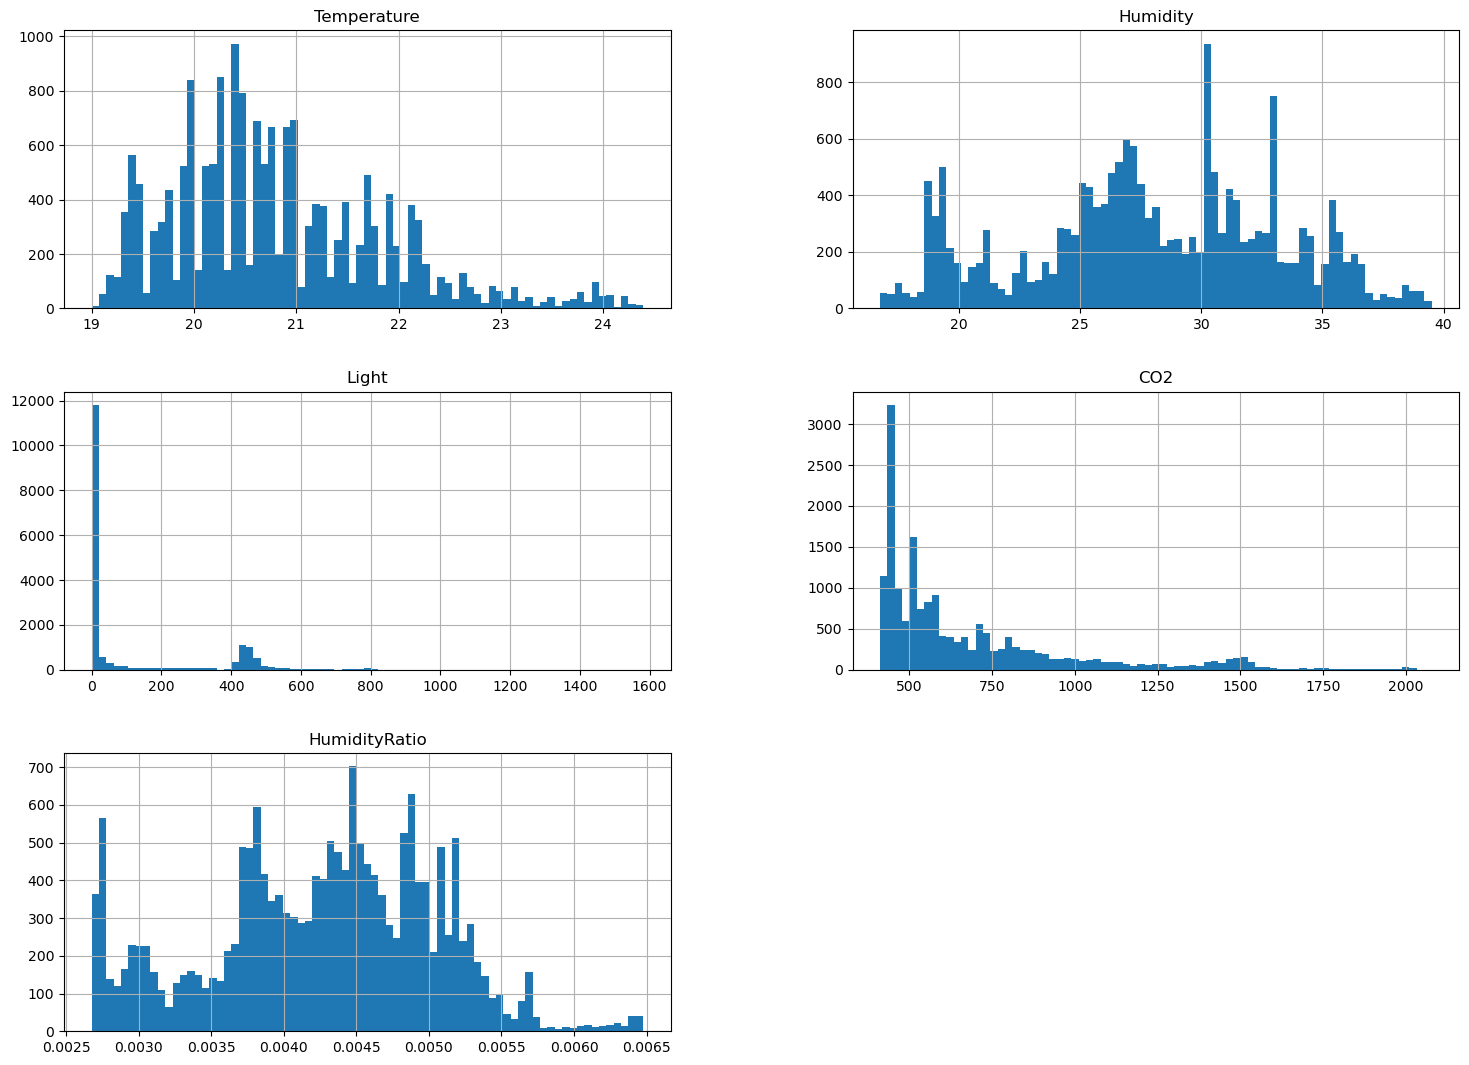

In [481]:
# Histogram of training data
X_train.hist(figsize=(18, 13), bins=75)
plt.show()

In [482]:
corr_mat = X_train.corr()
corr_mat

/tmp/ipykernel_14476/255316506.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = X_train.corr()


,Temperature,Humidity,Light,CO2,HumidityRatio
Temperature,1.000000,-0.188040,0.670851,0.394709,0.154630
Humidity,-0.188040,1.000000,-0.059196,0.276224,0.939622
Light,0.670851,-0.059196,1.000000,0.394740,0.175590
CO2,0.394709,0.276224,0.394740,1.000000,0.432989
HumidityRatio,0.154630,0.939622,0.175590,0.432989,1.000000


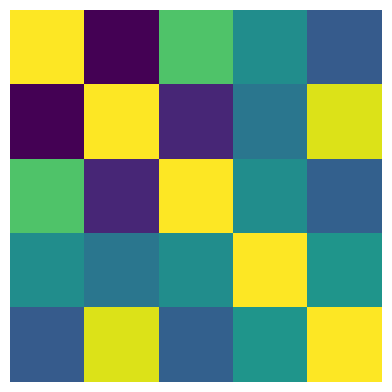

In [483]:
plt.matshow(corr_mat)
plt.axis('off')
plt.show()

Note: Because some features have reletivly strong correlation, we can combine them into a new features.\
Strong Correlation: 
1. Humidity-Tempeture
2. Humidity-Light
3. Humidity-CO2

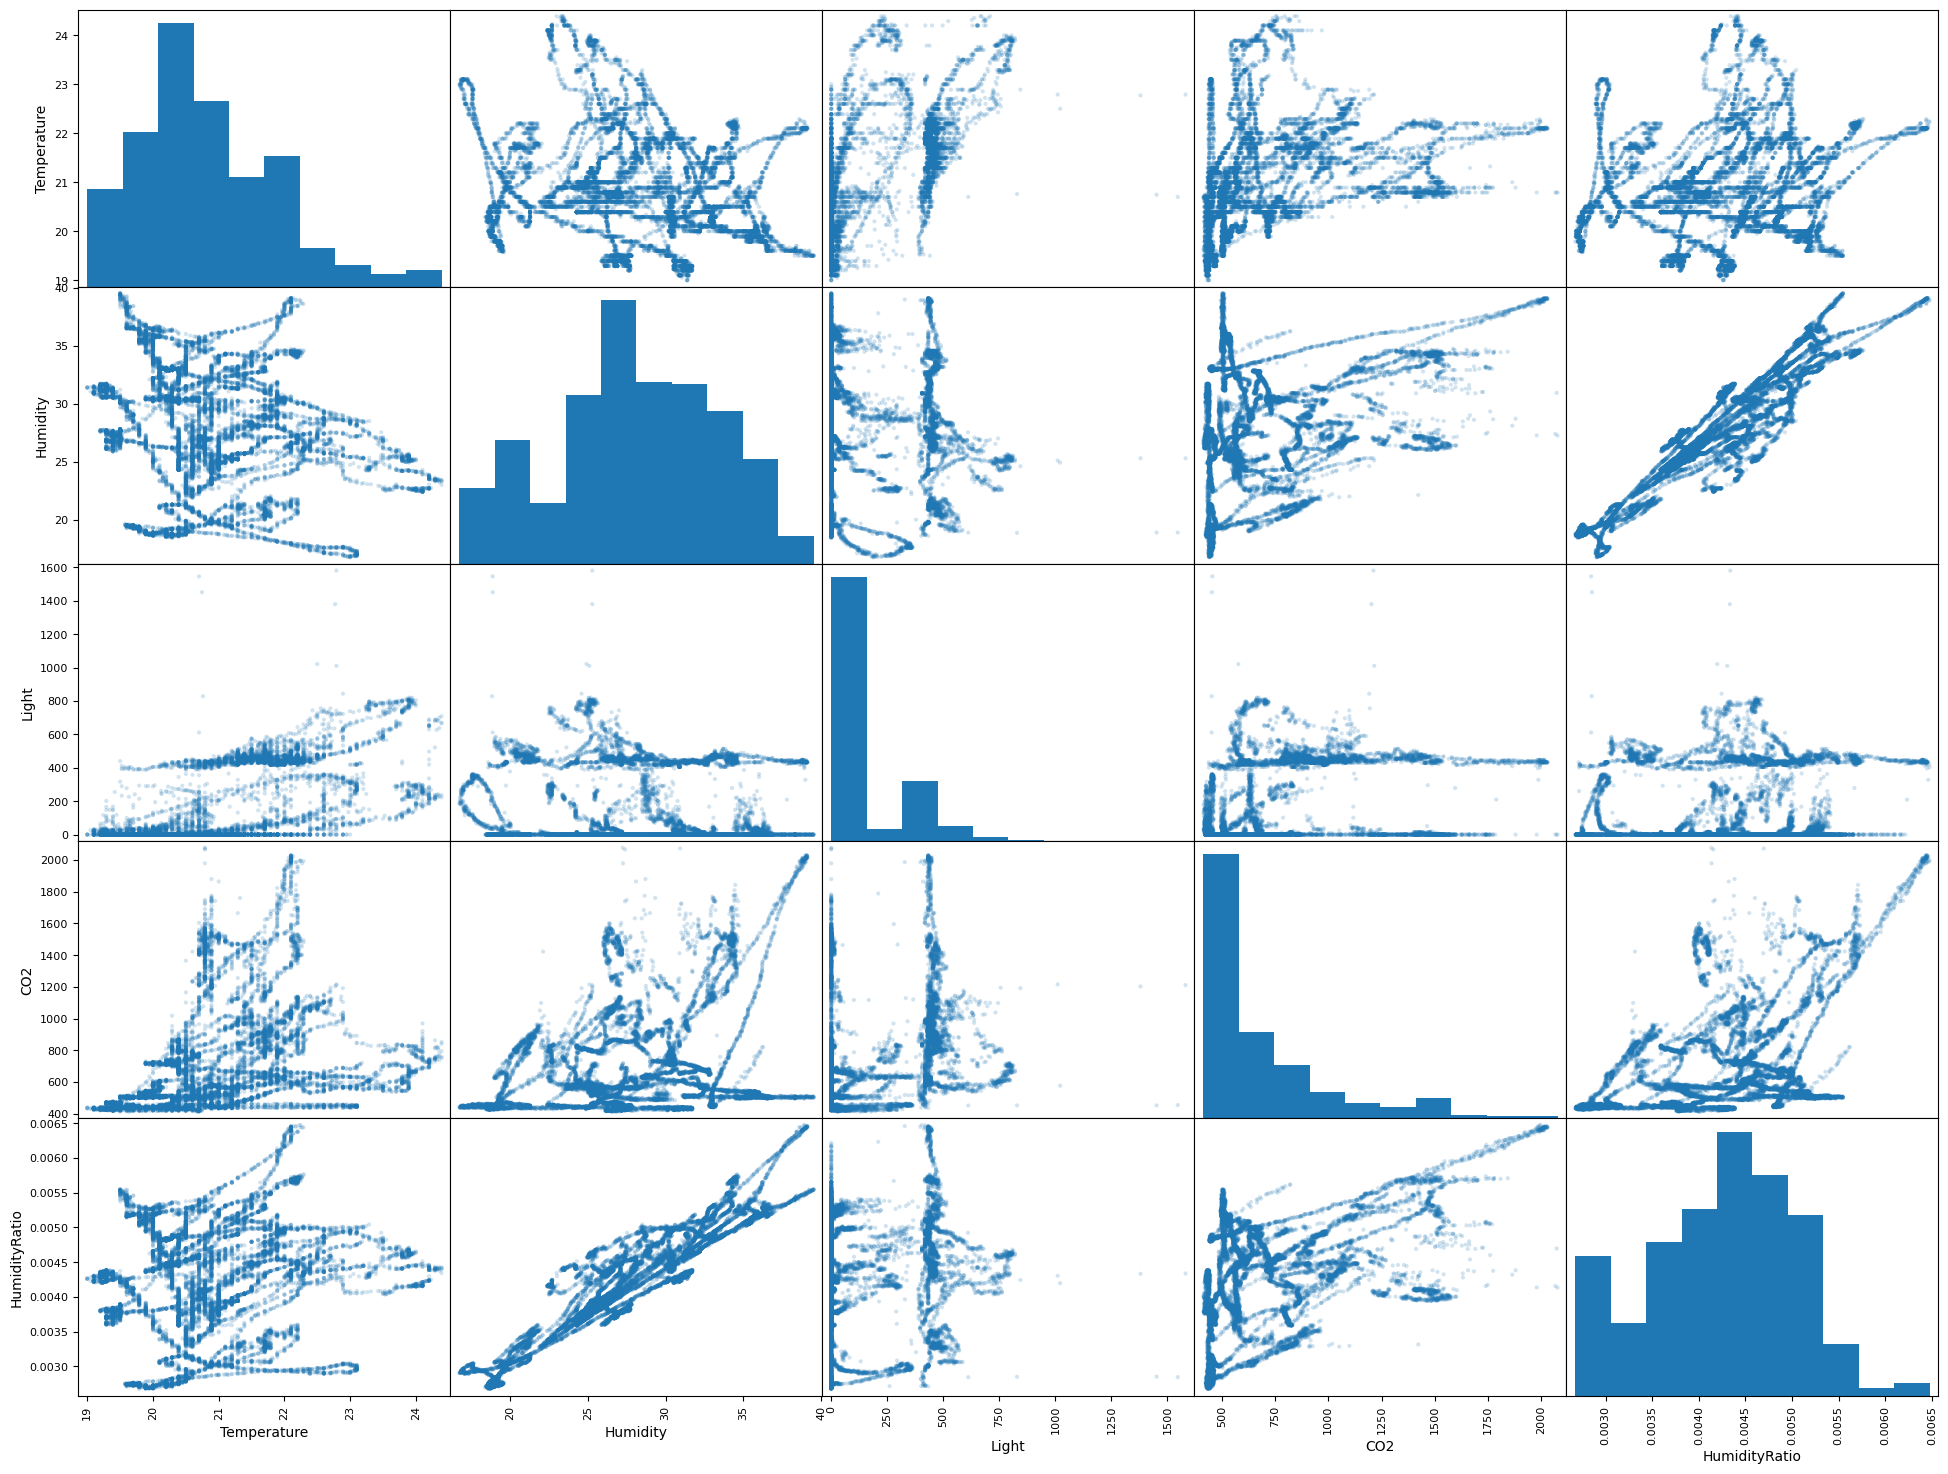

In [484]:
# Scatter Matrcx Plot
from pandas.plotting import scatter_matrix

scatter_matrix(X_train, figsize=(24, 18), alpha=0.2)
plt.show()

## Data Prepration

In [485]:
# Creating a Transformer to Combine Highly Corrrelated Features
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeCombination(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        combined_attributes = pd.DataFrame({
            'Temperature_Light': X['Temperature'] * X['Light'],
            'Temperature_CO2': X['Temperature'] * X['CO2'],
            'Humidity_CO2': X['Humidity'] * X['CO2'],
            'Light_CO2': X['Light'] * X['CO2'],
            'CO2_HiumidityRatio': X['CO2'] * X['HumidityRatio']
        })
        result = pd.concat([X, combined_attributes], axis=1)
        return result

In [486]:
# Creating a Transformer to Divide the Date into Numerical Parameters
from datetime import datetime

class DivideDate(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        date = pd.DataFrame(index=range(1, len(X) + 1))
        date['day'] = np.vectorize(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S').day)(X['date'])
        date['hour'] = np.vectorize(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)(X['date'])
        date['month'] = np.vectorize(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month)(X['date'])
        date['weekday'] = np.vectorize(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday())(X['date'])   
        
        X_copy = X.drop('date', axis=1)
        X_copy = pd.concat([X_copy, date], axis=1)
        return X_copy

In [487]:
# Creating a Transformer To Scale Features
from sklearn.preprocessing import StandardScaler

class SpecializedScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X)
        self.columnss = X.columns
        return self
    
    def transform(self, X):
        result = self.scaler.transform(X)
        return pd.DataFrame(result, columns=self.columnss)

In [488]:
# Create a Pipeline of Transformers
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

full_pipeline = Pipeline([
    # ('attr_adder', AttributeCombination()),
    ('divide_date', DivideDate()),
    ('standard_scaler', SpecializedScaler())
])

X_train_prepared = full_pipeline.fit_transform(X_train)

## Explore many different models and shortlist the best ones

In [505]:
# Create a Function to Evaluate Models
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

def evaluate_model(model, X, y, cv=3):
    model.fit(X, y)
    # Reporting Metrices on Model Traing on Seen Data
    y_pred_seen = model.predict(X)
    accuracy_seen = sum(y == y_pred_seen) / len(y_train)
    precision_seen = precision_score(y, y_pred_seen)
    recall_seen = recall_score(y, y_pred_seen)
    fpr_seen, tpr_seen, thresholds_seen = roc_curve(y, y_pred_seen)
    print('Accuracy on seen data: {:.4f}'.format(accuracy_seen * 100))
    print('Precision score on seen data: {:.4f}'.format(precision_seen))
    print('Recall score on seen data: {:.4f}'.format(recall_seen))
    print('AUC seen: {:.4f}'.format(auc(fpr_seen, tpr_seen) * 100))
    
    print('-' * 40)
    
    # Reporting Metrics on Model Training on Unseen Data
    y_pred_unseen = cross_val_predict(model, X, y, cv=cv)
    accuracy_unseen = sum(y == y_pred_unseen) / len(y_train)
    precision_unseen = precision_score(y, y_pred_unseen)
    recall_unseen = recall_score(y, y_pred_unseen)
    fpr_unseen, tpr_unseen, thresholds_unseen = roc_curve(y, y_pred_unseen)
    print('Accuracy on unseen data: {:.4f}'.format(accuracy_unseen * 100))
    print('Precision score on seen data: {:.4f}'.format(precision_unseen))
    print('Recall score on seen data: {:.4f}'.format(recall_unseen))
    print('AUC unseen: {:.4f}'.format(auc(fpr_unseen, tpr_unseen) * 100))

In [506]:
# Train and evaluate a Logistic Regression model
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
evaluate_model(log_clf, X_train_prepared, y_train) # 98.1950

Accuracy on seen data: 99.1282
Precision score on seen data: 0.9648
Recall score on seen data: 0.9950
AUC seen: 99.2633
----------------------------------------
Accuracy on unseen data: 99.0277
Precision score on seen data: 0.9649
Recall score on seen data: 0.9899
AUC unseen: 99.0154


In [504]:
# Train and evaluate a Stocastic Gradient Descent model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
evaluate_model(sgd_clf, X_train_prepared, y_train) # 98.5303

Accuracy on seen data: 99.1674
Precision score on seen data: 0.9649
Recall score on seen data: 0.9968
AUC seen: 99.3560
----------------------------------------
Accuracy on unseen data: 99.1338
Precision score on seen data: 0.9646
Recall score on seen data: 0.9955
AUC unseen: 99.2862


In [388]:
# Train and evaluate a KNN model
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
evaluate_model(knn_clf, X_train_prepared, y_train) # 94.0821

Accuracy on seen data: 99.5921
Precision score on seen data: 0.9879
Recall score on seen data: 0.9929
AUC seen: 99.4797
----------------------------------------
Accuracy on unseen data: 93.1210
Precision score on seen data: 0.8929
Recall score on seen data: 0.7660
AUC unseen: 87.0717


In [384]:
# Train and evaluate a SVM model
from sklearn.svm import SVC

svm_clf = SVC()
evaluate_model(svm_clf, X_train_prepared, y_train) # 97.9547

Accuracy on seen data: 99.1953
Precision score on seen data: 0.9652
Recall score on seen data: 0.9979
AUC seen: 99.4124
----------------------------------------
Accuracy on unseen data: 97.7592
Precision score on seen data: 0.9676
Recall score on seen data: 0.9248
AUC unseen: 95.8270


In [385]:
# Train and evaluate a Random Forest model
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
evaluate_model(forest_clf, X_train_prepared, y_train) # 96.1386

Accuracy on seen data: 100.0000
Precision score on seen data: 1.0000
Recall score on seen data: 1.0000
AUC seen: 100.0000
----------------------------------------
Accuracy on unseen data: 97.4742
Precision score on seen data: 0.9514
Recall score on seen data: 0.9277
AUC unseen: 95.7530


In [386]:
# Train and evaluate a XGBoost model
from sklearn.ensemble import GradientBoostingClassifier

xgboost_clf = GradientBoostingClassifier()
evaluate_model(xgboost_clf, X_train_prepared, y_train) # 95.7865

Accuracy on seen data: 99.5362
Precision score on seen data: 0.9807
Recall score on seen data: 0.9976
AUC seen: 99.6188
----------------------------------------
Accuracy on unseen data: 87.8402
Precision score on seen data: 0.6767
Recall score on seen data: 0.8121
AUC unseen: 85.4112


## Hyperparameter Tuning (Fine-tune)

In [467]:
# Using grid search to fine tune the model
from sklearn.model_selection import GridSearchCV

log_clf = LogisticRegression() 

param_grid = [
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.2, 0.5, 1.0]},
    {'solver': ['lbfgs'], 'penalty': [None]}
]

grid_search = GridSearchCV(log_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True)

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': [0.2, 0.5, 1.0], 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'penalty': [None], 'solver': ['lbfgs']}],
             return_train_score=True, scoring='accuracy')

In [468]:
# Best Parameters
print(grid_search.best_params_)
cvResults = grid_search.cv_results_
for mean_score, params in zip(cvResults['mean_test_score'] * 100, cvResults['params']):
    print(mean_score, params)

{'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
99.13378467418832 {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}
99.13937126636709 {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
99.13378155144255 {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
99.11702177490623 {'penalty': None, 'solver': 'lbfgs'}


## Evaluate Final Model on the Test Set

In [502]:
final_model = grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(X_test)
y_test_pred = final_model.predict(X_test_prepared)
accuracy = sum(y_test == y_test_pred) / len(X_test_prepared)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print('Accuracy on test set: {:.4f}'.format(accuracy * 100))
print('Precision score on test set: {:.4f}'.format(precision))
print('Recall score on test set: {:.4f}'.format(recall))
print('AUC on test set: {:.4f}'.format(auc(fpr, tpr) * 100))

Accuracy on test set: 97.8612
Precision score on test set: 0.9463
Recall score on test set: 0.9979
AUC on test set: 98.2728
